In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
import pandas as pd
import faiss                   # make faiss available
import umap
import seaborn as sns
%matplotlib inline
from byol_pytorch import BYOL

import os
import sys
import matplotlib.pyplot as plt
from sklearn import svm
sys.path.append('..')

import torchvision.models as models
from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from src.beam import UniversalDataset, Experiment, Algorithm, beam_arguments, PackedFolds

2022-07-24 13:11:09.622971: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
class FeatureNet(nn.Module):

    def __init__(self):

        super().__init__()
        net = models.resnet50(pretrained=True, num_classes=1000)
        # train_nodes, eval_nodes = get_graph_node_names(net)
        return_nodes = {
            'flatten': 'features',
        }
        self.net = create_feature_extractor(net, return_nodes=return_nodes)
        

    def forward(self, x):
        return self.net(x)['features'].view(len(x), -1)

In [3]:
class MiniImageNet(UniversalDataset):

    def __init__(self, hparams):

        path = hparams.path_to_data
        seed = hparams.split_dataset_seed

        super().__init__()
        
        file = os.path.join(path, 'mini_imagenet.pt')
        if not os.path.exists(file):
                        
            dataset_train = [pd.read_pickle(os.path.join(path, f'train_data_batch_{i}')) for i in range(1, 11)]


            data_train = torch.cat([torch.ByteTensor(di['data']) for di in dataset_train]).reshape(-1, 3, 64, 64)

            data_train_f = data_train.float()

            mu = data_train_f.mean(dim=(0, 2, 3), keepdim=True)
            std = data_train_f.std(dim=(0, 2, 3), keepdim=True)

            data_test = torch.ByteTensor(dataset_test['data']).reshape(-1, 3, 64, 64)

            labels_train = torch.cat([torch.LongTensor(di['labels']) for di in dataset_train])
            labels_test = torch.LongTensor(dataset_test['labels'])

            state = {'data_train': data_train, 'data_test': data_test, 
                            'labels_train': labels_train, 
                            'labels_test': labels_test, 'mu': mu,
                            'std': std}
            
            torch.save(state, file)
        else:
            state = torch.load(file)
        
        self.normalize = True
        self.data = PackedFolds({'train': state['data_train'], 'test': state['data_test']})
        self.labels = PackedFolds({'train': state['labels_train'], 'test': state['labels_test']})
        self.mu = state['mu']
        self.std = state['std']
        self.split(validation=.2, test=self.labels['test'].index, seed=seed)
        self.transform = torchvision.transforms.Resize((224, 224))

    def getitem(self, index):
        
        x = self.data[index]
        
        if self.normalize:
            mu = self.mu
            std = self.std
            
            if len(x.shape) == 3:
                mu = mu.squeeze(0)
                std = std.squeeze(0)
                
            x = (x.float() - mu) / std
            
        x = self.transform(x)
            
        return {'x': x, 'y': self.labels[index]}

In [4]:
class BeamBYOL(Algorithm):

    def __init__(self, hparams):

        # choose your network
        # net = FeatureNet()
        resnet = models.resnet50(pretrained=True)

        layer = 'avgpool'
        networks = {'learner': BYOL(resnet,
                                   image_size = 224,
                                   hidden_layer = layer)}
        
        return_nodes = {layer: 'features'}
        
        feature_extractor = create_feature_extractor(resnet, return_nodes=return_nodes)
        self.features = lambda x: feature_extractor(x)['features'].view(len(x), -1)
        
        super().__init__(hparams, networks=networks)

    
    def preprocess_epoch(self, results=None, **kwargs):
        
        self.dataset.normalize = True
        
        return results
    
    def postprocess_epoch(self, results=None, training=None, **kwargs):
        
        print('postprocess')
        
        if not training:
            
            print('validation')
            
            z = np.concatenate(results['transforms']['z'])
            y = np.concatenate(results['transforms']['y'])
            
            clf = LogisticRegression(max_iter=10)
            clf.fit(z, y)
            
            y_hat = clf.predict(z)
            results['scalar']['downstream'] = float(accuracy_score(y, y_pred=y_hat))
    
    def iteration(self, sample=None, results=None, counter=None, subset=None, training=True, **kwargs):

        x, y = sample['x'], sample['y']

        learner = self.networks['learner']
        opt = self.optimizers['learner']

        if training:
            loss = learner(x)
            opt.apply(loss, training=training)
            learner.update_moving_average()

            # add scalar measurements
            results['scalar']['loss'].append(float(loss))
        
        else:
            
            z = self.features(x)
            results['transforms']['z'].append(z.detach().cpu().numpy())
            results['transforms']['y'].append(y.detach().cpu().numpy())

        return results
    
    def inference(self, sample=None, results=None, subset=None, predicting=True, **kwargs):

        if predicting:
            x = sample
        else:
            x, y = sample['x'], sample['y']

        z = self.features(x)

        if not predicting:
            return {'z': z, 'y': y}, results

        return z, results

## set hparams

In [5]:
path_to_data = '/home/shared/data/dataset/imagenet'
root_dir = '/home/shared/data/results'

hparams = beam_arguments(
    f"--project-name=similarity --root-dir={root_dir} --algorithm=ImageNet --identifier=dev  --device=0 --amp",
    "--epoch-length-train=50 --epoch-length-eval=6 --no-scale-epoch-by-batch-size --batch-size=64",
    path_to_data=path_to_data)

## Build a dataset

In [6]:
%%time

dataset = MiniImageNet(hparams)

CPU times: user 9.18 s, sys: 40 s, total: 49.2 s
Wall time: 12.3 s


### Plot image from the data

In [7]:
dataset.normalize = False

In [8]:
im = np.array(dataset[10210][1]['x'].permute(1, 2, 0))

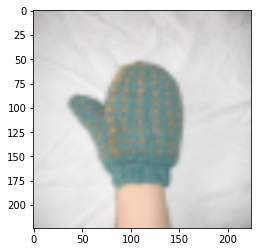

In [9]:
plt.imshow(im)

In [10]:
dataset.normalize = True

## Build Beam Experiment with BYOL trainer

In [11]:
experiment = Experiment(hparams, print_hyperparameters=False)

2022-07-24 13:11:33 | INFO | Creating new experiment
2022-07-24 13:11:33 | INFO | Experiment directory is: /home/shared/data/results/similarity/ImageNet/dev/0006_20220724_131133


In [12]:
# alg = experiment.algorithm_generator(BeamBYOL, dataset)

In [13]:
alg = experiment.fit(BeamBYOL, dataset)

2022-07-24 13:11:33 | INFO | Single worker mode
2022-07-24 13:11:33 | INFO | Worker: 1/1 is running...


train:   2%|2         | 1/50 [00:00<?, ?it/s]

postprocess


TypeError: 'NoneType' object is not subscriptable

In [17]:
features = alg.evaluate('test')

test:   0%|          | 1/782 [00:00<?, ?it/s]

In [36]:
features = alg.evaluate('test', max_iterations=100)

In [37]:
z = features.values['z'].detach().cpu().numpy()
y = features.values['y'].detach().cpu().numpy()

## Classifier

In [39]:
clf = LogisticRegression(max_iter=10)

In [40]:
%%time
clf.fit(z, y)

CPU times: user 1min 53s, sys: 6min 34s, total: 8min 27s
Wall time: 14.1 s


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=10)

In [41]:
y_hat = clf.predict(z)

In [43]:
accuracy_score(y, y_pred=y_hat)

0.79421875

In [20]:
clf = RandomForestClassifier(min_samples_leaf=20)
clf.fit(z, y)

KeyboardInterrupt: 

In [ ]:
# clf = svm.LinearSVC()

# clf.fit(z, y)

## Faiss

In [58]:
d = z.shape[-1]

In [59]:
# index = faiss.IndexFlatL2(d)   # build the index

In [60]:
res = faiss.StandardGpuResources()

In [61]:
# build a flat (CPU) index
index_flat = faiss.IndexFlatL2(d)
# make it into a gpu index
gpu_index_flat = faiss.index_cpu_to_gpu(res, 0, index_flat)

In [62]:
gpu_index_flat.add(z)         # add vectors to the index
print(gpu_index_flat.ntotal)

50000


In [63]:
index_flat.is_trained

True

In [64]:
# k = 4                          # we want to see 4 nearest neighbors
# D, I = gpu_index_flat.search(z[:5], k)  # actual search

# %%time

# # we want to see 4 nearest neighbors
# D, I = gpu_index_flat.search(z, k) # sanity check

In [65]:
i = 1000

In [66]:
y = features.data['y']

In [67]:
D, I = gpu_index_flat.search(z[[i]], 100) # sanity check

In [ ]:
len(np.unique(y[I[0]]))

In [68]:
zvi = z[I[0]]

In [69]:
reducer = umap.UMAP()

In [70]:
embedding = reducer.fit_transform(zvi)

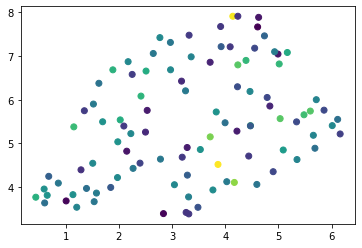

In [71]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=y[I[0]])

In [40]:
%%time

# we want to see 4 nearest neighbors
D, I = index.search(z, k) # sanity check

KeyboardInterrupt: 